**现代卷积神经网络**

@ Date: 2025-04-13<br>
@ Author: Rui Zhu<br>
@ Images From: https://d2l.ai/chapter_convolutional-modern/index.html<br>
@ 概览<br>
1. CNN从LeNet开始
2. AlexNet增加了网络层数, 并使用ReLU, 发现效果更好
3. VGG开始提出块的概念, 方便构造更复杂的网络, 并且发现更深更好
4. NiN使用全局平均汇聚替换全连接层, 减小模型参数, 防止过拟合
5. GoogLeNet引入包含子网络的Inception块

In [3]:
import torch
from torch import nn
from torch.nn import functional as F

---
# AlexNet
- AlexNet以Alex Krizhevsky的名字命名, 他是文章的第一作者
- AlexNet在2012年横空出世, 首次证明了学习到的特征可以超越手动设计的特征
- AlexNet的为ImageNet数据集设计
- AlexNet VS. LeNet
    1. AlexNet深的多: AlexNet有8个层组成, 其中5个卷积层、2个全连接隐藏层和1个全连接输出层
    2. AlexNet使用ReLU而不是sigmoid作为其激活函数
    3. 更大的卷积窗口: 因为ImageNet中的图像比MNIST图像大10倍以上, 需要用更大的卷积窗口来捕获窗口
    4. 使用ReLU: ReLU的计算更简单; sigmoid函数对输入敏感, ReLU使训练更容易
    5. 使用dropout方法控制全连接层的模型复杂度, 而LeNET只使用了权重衰减
    6. AlexNet在训练时增加了大量的图像增强数据, 如翻转、裁切和变色, 使模型更健壮, 更大的样本量有效地减少了过拟合

In [2]:
# 使用Fashion-MNIST数据集(原始论文AlexNet使用ImageNet数据集, 但过于庞大, 训练时间过长)
from astrokit.ML import d2l
dir_data = "/Users/rui/Code/Astronote/32_PyTorch/data/chapter7"
batch_size = 128
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size, resize=224, dir_data=dir_data)

In [3]:
net = nn.Sequential(
    nn.Conv2d(1, 96, kernel_size=11, stride=4, padding=1), nn.ReLU(), 
    nn.MaxPool2d(kernel_size=3, stride=2), 
    nn.Conv2d(96, 256, kernel_size=5, padding=2), nn.ReLU(),
    nn.MaxPool2d(kernel_size=3, stride=2), 
    nn.Conv2d(256, 384, kernel_size=3, padding=1), nn.ReLU(),
    nn.Conv2d(384, 384, kernel_size=3, padding=1), nn.ReLU(),
    nn.Conv2d(384, 256, kernel_size=3, padding=1), nn.ReLU(),
    nn.MaxPool2d(kernel_size=3, stride=2),
    nn.Flatten(),
    nn.Linear(6400, 4096), nn.ReLU(),
    nn.Dropout(p=0.5),
    nn.Linear(4096, 4096), nn.ReLU(),
    nn.Dropout(p=0.5),
    nn.Linear(4096, 10)
)

train loss: 0.330, train acc: 0.878, test acc: 0.882
364.7 examples/sec on mps


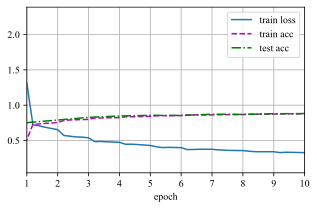

In [4]:
lr, num_epochs = 0.01, 10
d2l.train_net(net, train_iter, test_iter, num_epochs, lr, torch.device('mps'))

---
# VGG
- VGG 是一种 深度卷积神经网络结构, 最早由牛津大学视觉几何组（Visual Geometry Group）提出, 因此得名VGG
- 核心思想: 
    1. 更高层次上抽象层的概念, 称为块(block)
    2. 使用`可复用的卷积块`构造网络, 有效地设计复杂网络
    3. 发现: 深层且窄的卷积(如3x3)比浅层且宽的卷积更有效

In [9]:
def vgg_block(num_convs, in_channels, out_channels):
    """
    实现一个VGG块

    Parameters
    ----------
    num_convs : int
        卷积层的数量
    in_channels : int
        输入通道数
    out_channels : int
        输出通道数
    """
    layers = []
    for _ in range(num_convs):
        layers.append(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1)
        )
        layers.append(nn.ReLU())
        in_channels = out_channels
    layers.append(nn.MaxPool2d(kernel_size=2, stride=2))
    return nn.Sequential(*layers)

def vgg(conv_arch):
    """
    定义VGG网络, 即VGG-11
    该网络中有8个卷积层和3个全连接层, 因此称为VGG-11

    Parameters
    ----------
    conv_arch : list
        定义每个VGG块中卷积层个数和输出通道数
    """
    conv_blks = []
    in_channels = 1
    for (num_convs, out_channels) in conv_arch:
        conv_blks.append(vgg_block(num_convs, in_channels, out_channels))
        in_channels = out_channels
    
    net = nn.Sequential(
        *conv_blks, nn.Flatten(),
        # 全连接层
        nn.Linear(out_channels * 7 * 7, 4096), nn.ReLU(), nn.Dropout(p=0.5),
        nn.Linear(4096, 4096), nn.ReLU(), nn.Dropout(p=0.5),
        nn.Linear(4096, 10)
    )
    return net

In [10]:
conv_arch = ((1, 64), (1, 128), (2, 256), (2, 512), (2, 512))
net = vgg(conv_arch)

# 测试网络
X = torch.randn(1, 1, 224, 224)
for blk in net:
    X = blk(X)
    print(blk.__class__.__name__, 'output shape:\t', X.shape)

Sequential output shape:	 torch.Size([1, 64, 112, 112])
Sequential output shape:	 torch.Size([1, 128, 56, 56])
Sequential output shape:	 torch.Size([1, 256, 28, 28])
Sequential output shape:	 torch.Size([1, 512, 14, 14])
Sequential output shape:	 torch.Size([1, 512, 7, 7])
Flatten output shape:	 torch.Size([1, 25088])
Linear output shape:	 torch.Size([1, 4096])
ReLU output shape:	 torch.Size([1, 4096])
Dropout output shape:	 torch.Size([1, 4096])
Linear output shape:	 torch.Size([1, 4096])
ReLU output shape:	 torch.Size([1, 4096])
Dropout output shape:	 torch.Size([1, 4096])
Linear output shape:	 torch.Size([1, 10])


In [11]:
# 原始VGG-11用于ImageNet数据集, 这里使用Fashion-MNIST数据集, 需要降低模型复杂度
# 降低每个VGG块的输出通道数, 使得模型参数量和计算量更小
ratio = 4
small_conv_arch = [(num_convs, out_channels // ratio) for (num_convs, out_channels) in conv_arch]
print(small_conv_arch)

[(1, 16), (1, 32), (2, 64), (2, 128), (2, 128)]


train loss: 0.177, train acc: 0.934, test acc: 0.918
532.3 examples/sec on mps


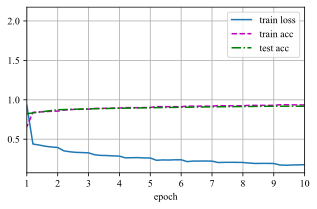

In [12]:
net = vgg(small_conv_arch)
lr, num_epochs, batch_size = 0.05, 10, 128
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size, resize=224, dir_data=dir_data)
d2l.train_net(net, train_iter, test_iter, num_epochs, lr, torch.device('mps'))

---
# NiN
- NiN: Network in Network
- NiN完全取消了全连接层, 显著减少模型的参数数量, 减少过拟合(但并不一定会减少训练时间)
- NiN块: 输出通道数量等于标签类别数
- 全局平均汇聚层(Global average pooling layer): 每个通道的输出将是一个数值，它是这个通道中所有像素的平均值
- NiN结构: (NiN块 + 3x3最大汇聚) * 3 + (NiN块 + 全局平均汇聚层)

In [13]:
def nin_block(in_channels, out_channels, kernel_size, strides, padding):
    block = nn.Sequential(
        nn.Conv2d(in_channels, out_channels, kernel_size, strides, padding), 
        nn.ReLU(),
        nn.Conv2d(out_channels, out_channels, kernel_size=1),  # 1x1卷积, 相当于针对像素位置上的全连接层
        nn.ReLU(),
        nn.Conv2d(out_channels, out_channels, kernel_size=1),  # 1x1卷积, 相当于针对像素位置上的全连接层
        nn.ReLU(),
    )
    return block

net = nn.Sequential(
    nin_block(1, 96, kernel_size=11, strides=4, padding=0), 
    nn.MaxPool2d(3, stride=2), 
    nin_block(96, 256, kernel_size=5, strides=1, padding=2), 
    nn.MaxPool2d(3, stride=2),
    nin_block(256, 384, kernel_size=3, strides=1, padding=1),
    nn.MaxPool2d(3, stride=2), 
    nn.Dropout(p=0.5),
    nin_block(384, 10, kernel_size=3, strides=1, padding=1),
    nn.AdaptiveAvgPool2d((1, 1)),  # 自适应平均池化, 自动根据目标输出大小来计算池化参数
    nn.Flatten(),
)

In [14]:
X = torch.rand(size=(1, 1, 224, 224))
for layer in net:
    X = layer(X)
    print(layer.__class__.__name__, 'output shape:\t', X.shape)

Sequential output shape:	 torch.Size([1, 96, 54, 54])
MaxPool2d output shape:	 torch.Size([1, 96, 26, 26])
Sequential output shape:	 torch.Size([1, 256, 26, 26])
MaxPool2d output shape:	 torch.Size([1, 256, 12, 12])
Sequential output shape:	 torch.Size([1, 384, 12, 12])
MaxPool2d output shape:	 torch.Size([1, 384, 5, 5])
Dropout output shape:	 torch.Size([1, 384, 5, 5])
Sequential output shape:	 torch.Size([1, 10, 5, 5])
AdaptiveAvgPool2d output shape:	 torch.Size([1, 10, 1, 1])
Flatten output shape:	 torch.Size([1, 10])


train loss: 0.336, train acc: 0.876, test acc: 0.880
381.8 examples/sec on mps


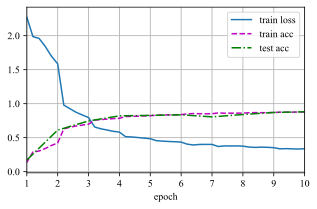

In [15]:
lr, num_epochs, batch_size = 0.1, 10, 128
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size, resize=224, dir_data=dir_data)
d2l.train_net(net, train_iter, test_iter, num_epochs, lr, torch.device('mps'))

---
# GoogLeNet
- 解决了多大卷积核最合适的问题
- 发现使用不同大小的卷积核组合是有利的
- Inception块: 
1. 架构如图所示, 包含4条并行的路径, 每条路径使用不同大小的卷积核, 使用合适的填充使最终的输出与输入的高度和宽度一致
2. Inception块是有4条路径的子网络
3. Inception块使用1x1卷积层减少通道数, 降低模型复杂度
4. Inception块的通道数分配是通过实验确定的
    <br><img src="figs/inception.png" width="500"/>

- GoogLeNet架构:
1. 使用了9个Inception块
2. Inception块之间的最大汇聚层可降低维度
3. Inception块之前的块结构类似AlexNet和LeNet
4. Inception块组合的设计从VGG继承
5. 最后继承NiN的设计, 在最后使用全局平均汇聚层替代全连接层
    <br><img src="figs/googlenet.png" width="500"/>

In [4]:
class Inception(nn.Module):
    """
    实现Inception块

    Parameters
    ----------
    in_channels : int
        输入通道数
    c1-c4是每条路径的输出通道数
    """
    def __init__(self, in_channels, c1, c2, c3, c4, **kwargs):
        super(Inception, self).__init__(**kwargs)  # 调用父类的构造函数
        # 路径1, 单一1x1卷积
        self.p1_1 = nn.Conv2d(in_channels, c1, kernel_size=1)
        # 路径2, 1x1卷积 + 3x3卷积
        self.p2_1 = nn.Conv2d(in_channels, c2[0], kernel_size=1)
        self.p2_2 = nn.Conv2d(c2[0], c2[1], kernel_size=3, padding=1)
        # 路径3, 1x1卷积 + 5x5卷积
        self.p3_1 = nn.Conv2d(in_channels, c3[0], kernel_size=1)
        self.p3_2 = nn.Conv2d(c3[0], c3[1], kernel_size=5, padding=2)
        # 路径4, 3x3最大池化 + 1x1卷积
        self.p4_1 = nn.MaxPool2d(kernel_size=3, stride=1, padding=1)
        self.p4_2 = nn.Conv2d(in_channels, c4, kernel_size=1)

    def forward(self, X):
        p1 = F.relu(self.p1_1(X))
        p2 = F.relu(self.p2_2(F.relu(self.p2_1(X))))
        p3 = F.relu(self.p3_2(F.relu(self.p3_1(X))))
        p4 = F.relu(self.p4_2(self.p4_1(X)))
        # 拼接四条路径的输出
        return torch.cat((p1, p2, p3, p4), dim=1)

In [5]:
"""
搭建GoogLeNet网络
"""
# b1: 7x7卷积 + 3x3最大池化
b1 = nn.Sequential(nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3),
                   nn.ReLU(), 
                   nn.MaxPool2d(kernel_size=3, stride=2, padding=1))

# b2: 1x1卷积 + 3x3卷积 + 3x3最大池化
b2 = nn.Sequential(nn.Conv2d(64, 64, kernel_size=1), 
                   nn.ReLU(), 
                   nn.Conv2d(64, 192, kernel_size=3, padding=1),
                   nn.ReLU(), 
                   nn.MaxPool2d(kernel_size=3, stride=2, padding=1))

# b3: 2个Inception块 + 3x3最大池化
b3 = nn.Sequential(Inception(192, 64, (128, 128), (16, 32), 32),
                   Inception(256, 128, (128, 192), (32, 96), 64),
                   nn.MaxPool2d(kernel_size=3, stride=2, padding=1))

# b4: 5个Inception块 + 3x3最大池化
b4 = nn.Sequential(Inception(480, 192, (96, 208), (16, 48), 64),
                   Inception(512, 160, (112, 224), (24, 64), 64),
                   Inception(512, 128, (128, 256), (24, 64), 64),
                   Inception(512, 112, (144, 288), (32, 64), 64),
                   Inception(528, 256, (160, 320), (32, 128), 128),
                   nn.MaxPool2d(kernel_size=3, stride=2, padding=1))

# b5: 2个Inception块 + 全局平均池化
b5 = nn.Sequential(Inception(832, 256, (160, 320), (32, 128), 128),
                   Inception(832, 384, (192, 384), (48, 128), 128),
                   nn.AdaptiveAvgPool2d((1, 1)), 
                   nn.Flatten())

net = nn.Sequential(b1, b2, b3, b4, b5, nn.Linear(1024, 10))

In [6]:
X = torch.rand(size=(1, 1, 96, 96))
for layer in net:
    X = layer(X)
    print(layer.__class__.__name__, 'output shape:\t', X.shape)

Sequential output shape:	 torch.Size([1, 64, 24, 24])
Sequential output shape:	 torch.Size([1, 192, 12, 12])
Sequential output shape:	 torch.Size([1, 480, 6, 6])
Sequential output shape:	 torch.Size([1, 832, 3, 3])
Sequential output shape:	 torch.Size([1, 1024])
Linear output shape:	 torch.Size([1, 10])


In [ ]:
# 224x224的输入很耗时, 因此使用96x96的输入
lr, num_epochs, batch_size = 0.1, 10, 128
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size, resize=96, dir_data=dir_data)
d2l.train_net(net, train_iter, test_iter, num_epochs, lr, torch.device('mps'))